In [1]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.4 MB/s eta 0:00:00


## Preprocessing

In [118]:
# Import our dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical


In [3]:
# ID feature is already dropped from cleaning notebook
# Define the paths for all source files

# Open all source files as a pd dataframe
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/Michael/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

In [4]:
orig_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
# Split our preprocessed data into our features and target arrays
y_all = trainable_data['quality']
X_all = trainable_data.drop(columns = ['quality'])

In [11]:
y_all_df=pd.DataFrame(y_all)
display(y_all_df)
y_all_df.value_counts()

,quality
0,5
1,5
2,5
3,6
4,5
...,...
8548,7
8549,5
8550,8
8551,5


quality
6          3614
5          2977
7          1412
4           271
8           232
3            42
9             5
dtype: int64

In [15]:
y_all_cat = to_categorical(y_all)
print(f"Number of categories to classify: {len(y_all_cat[0])}")
print("---------------------")
y_all_cat_df = pd.DataFrame(y_all_cat)
display(y_all_cat_df)
y_all_cat_df.value_counts()

Number of categories to classify: 10
---------------------


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8549,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8551,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


0    1    2    3    4    5    6    7    8    9  
0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0    3614
                         1.0  0.0  0.0  0.0  0.0    2977
                         0.0  0.0  1.0  0.0  0.0    1412
                    1.0  0.0  0.0  0.0  0.0  0.0     271
                    0.0  0.0  0.0  0.0  1.0  0.0     232
               1.0  0.0  0.0  0.0  0.0  0.0  0.0      42
               0.0  0.0  0.0  0.0  0.0  0.0  1.0       5
dtype: int64

In [17]:
# Split the preprocessed data into a training and testing dataset
X_train_all, X_val_all, y_train_c_all, y_val_c_all = train_test_split(X_all,
                                                                      y_all_cat,
                                                                      test_size = 0.2,
                                                                      random_state=42)


In [27]:
# Create a StandardScaler instances
scaler_all = StandardScaler()


# Fit the StandardScaler
X_train_all_scaler = scaler_all.fit(X_train_all)

# Scale the data
X_train_all_scaled = X_train_all_scaler.transform(X_train_all)
X_val_all_scaled = X_train_all_scaler.transform(X_val_all)

## Compile, Train and Evaluate the Model

In [28]:
len(y_all_cat[0])

10

In [29]:
len(X_train_all_scaled[0])

11

In [37]:
# Influenced by In-class Activity Module 21.2 'tune_up_solution' and Keras docs: https://www.tensorflow.org/tutorials/keras/keras_tuner
# Create a method that creates a new Sequential model with hyperparameter options
def create_model_all(hp):
    num_class = len(y_all_cat[0])
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu', 'tanh', 'sigmoid','selu'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
                                                    min_value=1,
                                                    max_value=len(X_train_all_scaled[0]),
                                                    step=2),
                                       activation = activation,
                                       input_dim = len(X_train_all_scaled[0])
                                       ))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units = hp.Int('units_' + str(i),
                                                        min_value = 1,
                                                        max_value = len(X_train_all_scaled[0])*2,
                                                        step=5),
                                           activation=activation
        ))

    nn_model.add(tf.keras.layers.Dense(units=num_class,
                                       activation="softmax"
                                       ))

    # Compile the model
    nn_model.compile(loss="categorical_crossentropy",
                     optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                     metrics=["accuracy"])

    return nn_model


In [38]:
# Define the tuner
tuner_all = kt.Hyperband(
    create_model_all,
    objective="val_accuracy",
    directory='all_trainable_data',
    project_name= 'all_trainable',
    max_epochs=10,
    hyperband_iterations=5)



In [39]:
# Run the kerastuner search for best hyperparameters
tuner_all.search(X_train_all_scaled,
                 y_train_c_all,
                 epochs=50,
                 validation_data=(X_val_all_scaled,
                                  y_val_c_all)
                 )

Trial 150 Complete [00h 00m 07s]
val_accuracy: 0.5505552291870117

Best val_accuracy So Far: 0.564582109451294
Total elapsed time: 00h 12m 59s


In [40]:
# Create zip file of trial results incase Colag instance fails/disconnects
!zip -r /content/all_trainable_data.zip /content/all_trainable_data

  adding: content/all_trainable_data/ (stored 0%)
  adding: content/all_trainable_data/all_trainable/ (stored 0%)
  adding: content/all_trainable_data/all_trainable/trial_0042/ (stored 0%)
  adding: content/all_trainable_data/all_trainable/trial_0042/checkpoint.index (deflated 63%)
  adding: content/all_trainable_data/all_trainable/trial_0042/checkpoint (deflated 48%)
  adding: content/all_trainable_data/all_trainable/trial_0042/checkpoint.data-00000-of-00001 (deflated 30%)
  adding: content/all_trainable_data/all_trainable/trial_0042/trial.json (deflated 77%)
  adding: content/all_trainable_data/all_trainable/trial_0058/ (stored 0%)
  adding: content/all_trainable_data/all_trainable/trial_0058/checkpoint.index (deflated 62%)
  adding: content/all_trainable_data/all_trainable/trial_0058/checkpoint (deflated 48%)
  adding: content/all_trainable_data/all_trainable/trial_0058/checkpoint.data-00000-of-00001 (deflated 31%)
  adding: content/all_trainable_data/all_trainable/trial_0058/trial.

In [42]:
# Get top 5 model hyperparameters and print the values
top_hyper_all = tuner_all.get_best_hyperparameters(5)
print("Top 5 Keras search hyperparameters in order of best to worst:")
for i, param in enumerate(top_hyper_all, start = 1):
  print()
  print(f'--Number {i}------------------------------') # https://www.w3schools.com/python/ref_func_enumerate.asp
  print()
  print(param.values)

Top 5 Keras search hyperparameters in order of best to worst:

--Number 1------------------------------

{'activation': 'tanh', 'first_units': 11, 'num_layers': 3, 'units_0': 1, 'learning_rate': 0.01, 'units_1': 21, 'units_2': 11, 'units_3': 11, 'units_4': 11, 'units_5': 16, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}

--Number 2------------------------------

{'activation': 'relu', 'first_units': 11, 'num_layers': 4, 'units_0': 21, 'learning_rate': 0.001, 'units_1': 21, 'units_2': 21, 'units_3': 11, 'units_4': 16, 'units_5': 21, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0049'}

--Number 3------------------------------

{'activation': 'relu', 'first_units': 9, 'num_layers': 5, 'units_0': 16, 'learning_rate': 0.01, 'units_1': 11, 'units_2': 1, 'units_3': 21, 'units_4': 21, 'units_5': 21, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/ro

In [43]:
# Get the optimal hyperparameters
best_hps_all=tuner_all.get_best_hyperparameters(num_trials=1)[0]

In [47]:
# Get the optimal hyperparameters
best_hps_all=tuner_all.get_best_hyperparameters(num_trials=1)[0]

# Create callbacks
callbacks_all_best = [
    # Create a stop early call back to prevent possible overfitting: https://www.tensorflow.org/tutorials/keras/keras_tuner
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),

    # Create model checkpoint callback
    tf.keras.callbacks.ModelCheckpoint(
      filepath = 'all_trainable_best_hp/checkpoint_Epoch-{epoch:03d}_Accuracy-{accuracy:.4f}.h5',
      save_weigths_only= True,
      save_freq = 'epoch',
      period = 5,
      monitor= 'accuracy',
      mode= 'max', # set to max because checkpoint is monitoring accuracy - swithch to 'min' if monitoring loss
      verbose = 2
      )
    ]

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model_nn_all = tuner_all.hypermodel.build(best_hps_all)

In [48]:
model_nn_all.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 11)                132       
                                                                 
 dense_4 (Dense)             (None, 1)                 12        
                                                                 
 dense_5 (Dense)             (None, 21)                42        
                                                                 
 dense_6 (Dense)             (None, 11)                242       
                                                                 
 dense_7 (Dense)             (None, 10)                120       
                                                                 
Total params: 548
Trainable params: 548
Non-trainable params: 0
_________________________________________________________________


In [49]:
history_all = model_nn_all.fit(X_train_all_scaled,
                               y_train_c_all,
                               epochs = 100,
                               validation_data=(X_val_all_scaled,
                                                y_val_c_all),
                           callbacks = [callbacks_all_best])

val_acc_per_epoch_all = history_all.history['val_accuracy']
best_epoch_all = val_acc_per_epoch_all.index(max(val_acc_per_epoch_all)) + 1
print('Best epoch: %d' % (best_epoch_all,))

Epoch 1/100
214/214 [==============================] - 2s 3ms/step - loss: 1.1789 - accuracy: 0.5177 - val_loss: 1.0913 - val_accuracy: 0.5319
Epoch 2/100
214/214 [==============================] - 1s 3ms/step - loss: 1.0848 - accuracy: 0.5481 - val_loss: 1.0847 - val_accuracy: 0.5342
Epoch 3/100
214/214 [==============================] - 1s 3ms/step - loss: 1.0706 - accuracy: 0.5455 - val_loss: 1.0749 - val_accuracy: 0.5383
Epoch 4/100
214/214 [==============================] - 1s 3ms/step - loss: 1.0645 - accuracy: 0.5541 - val_loss: 1.0732 - val_accuracy: 0.5289
Epoch 5/100
194/214 [==========================>...] - ETA: 0s - loss: 1.0553 - accuracy: 0.5548
Epoch 5: saving model to all_trainable_best_hp/checkpoint_Epoch-005_Accuracy-0.5522.h5
214/214 [==============================] - 1s 3ms/step - loss: 1.0578 - accuracy: 0.5522 - val_loss: 1.0680 - val_accuracy: 0.5359
Epoch 6/100
214/214 [==============================] - 1s 3ms/step - loss: 1.0578 - accuracy: 0.5548 - val_loss: 

In [50]:
# Create zip file of trial results incase Colag instance fails/disconnects
!zip -r /content/all_trainable_best_hp.zip /content/all_trainable_best_hp

  adding: content/all_trainable_best_hp/ (stored 0%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-080_Accuracy-0.5728.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-075_Accuracy-0.5740.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-100_Accuracy-0.5738.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-055_Accuracy-0.5741.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-020_Accuracy-0.5593.h5 (deflated 82%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-095_Accuracy-0.5747.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-060_Accuracy-0.5726.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-010_Accuracy-0.5547.h5 (deflated 82%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-065_Accuracy-0.5678.h5 (deflated 81%)
  adding: content/all_trainable_best_hp/checkpoint_Epoch-030_Accuracy-0.5685.h5 (deflated 82

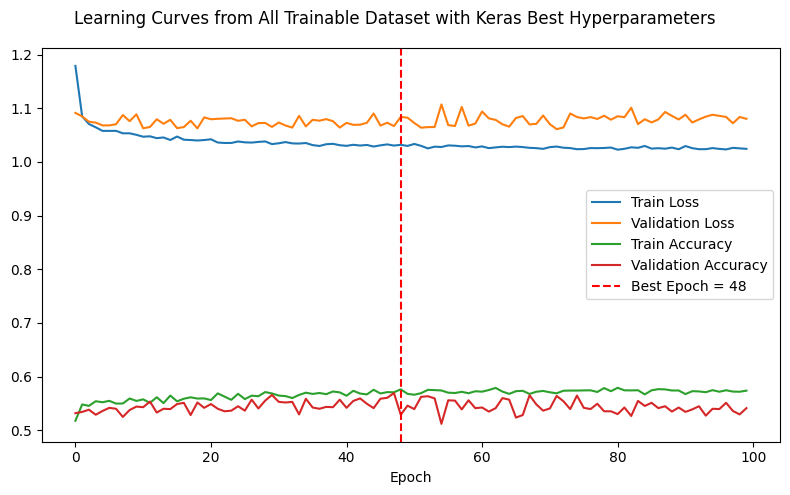

In [92]:
plt.figure(figsize=(8, 5))

# Plot training loss curve
plt.plot(history_all.history['loss'], label='Train Loss')
plt.plot(history_all.history['val_loss'], label='Validation Loss')

# Plot training accuracy curve
plt.plot(history_all.history['accuracy'], label='Train Accuracy')
plt.plot(history_all.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')


# Add vertical line Best Epoch
best_epoch_legend = f'Best Epoch = {best_epoch_all}'
plt.axvline(x=best_epoch_all, color='r', linestyle='--', label=best_epoch_legend)

plt.suptitle('Learning Curves from All Trainable Dataset with Keras Best Hyperparameters')


plt.legend()
plt.tight_layout()
plt.savefig('All trainable data loss and accuracy charts.png')

plt.show()

In [94]:
hypermodel_all = tuner_all.hypermodel.build(best_hps_all)

# Create callbacks
callbacks_all_retrain = [
    # Create a stop early call back to prevent possible overfitting: https://www.tensorflow.org/tutorials/keras/keras_tuner
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),

    # Create model checkpoint callback
    tf.keras.callbacks.ModelCheckpoint(
      filepath = 'all_trainable_retrain/checkpoint_Epoch-{epoch:03d}_Accuracy-{accuracy:.4f}.h5',
      save_weigths_only= True,
      save_freq = 'epoch',
      monitor= 'accuracy',
      mode= 'max', # set to max because checkpoint is monitoring accuracy - swithch to 'min' if monitoring loss
      verbose = 1
      )
    ]

# Retrain the model
hypermodel_fit_all = hypermodel_all.fit(X_train_all_scaled,
                                        y_train_c_all,
                                        epochs=best_epoch_all,
                                        validation_data=(X_val_all_scaled,
                                                y_val_c_all),
                                    callbacks = [callbacks_all_retrain])

Epoch 1/48
211/214 [============================>.] - ETA: 0s - loss: 1.1887 - accuracy: 0.5255
Epoch 1: saving model to all_trainable_retrain/checkpoint_Epoch-001_Accuracy-0.5262.h5
214/214 [==============================] - 2s 4ms/step - loss: 1.1862 - accuracy: 0.5262 - val_loss: 1.1039 - val_accuracy: 0.5283
Epoch 2/48
214/214 [==============================] - ETA: 0s - loss: 1.0852 - accuracy: 0.5436
Epoch 2: saving model to all_trainable_retrain/checkpoint_Epoch-002_Accuracy-0.5436.h5
214/214 [==============================] - 1s 3ms/step - loss: 1.0852 - accuracy: 0.5436 - val_loss: 1.0818 - val_accuracy: 0.5476
Epoch 3/48
190/214 [=========================>....] - ETA: 0s - loss: 1.0751 - accuracy: 0.5472
Epoch 3: saving model to all_trainable_retrain/checkpoint_Epoch-003_Accuracy-0.5484.h5
214/214 [==============================] - 1s 2ms/step - loss: 1.0716 - accuracy: 0.5484 - val_loss: 1.0784 - val_accuracy: 0.5541
Epoch 4/48
209/214 [============================>.] - ETA:

In [95]:
hypermodel_all.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 11)                132       
                                                                 
 dense_9 (Dense)             (None, 1)                 12        
                                                                 
 dense_10 (Dense)            (None, 21)                42        
                                                                 
 dense_11 (Dense)            (None, 11)                242       
                                                                 
 dense_12 (Dense)            (None, 10)                120       
                                                                 
Total params: 548
Trainable params: 548
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Create zip file of trial results incase Colag instance fails/disconnects
!zip -r /content/all_trainable_retrain.zip /content/all_trainable_retrain

  adding: content/all_trainable_retrain/ (stored 0%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-047_Accuracy-0.5691.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-034_Accuracy-0.5621.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-024_Accuracy-0.5627.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-017_Accuracy-0.5627.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-043_Accuracy-0.5672.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-008_Accuracy-0.5541.h5 (deflated 82%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-019_Accuracy-0.5571.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-004_Accuracy-0.5503.h5 (deflated 82%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-022_Accuracy-0.5590.h5 (deflated 81%)
  adding: content/all_trainable_retrain/checkpoint_Epoch-023_Accuracy-0.5630.h5 (deflated 81

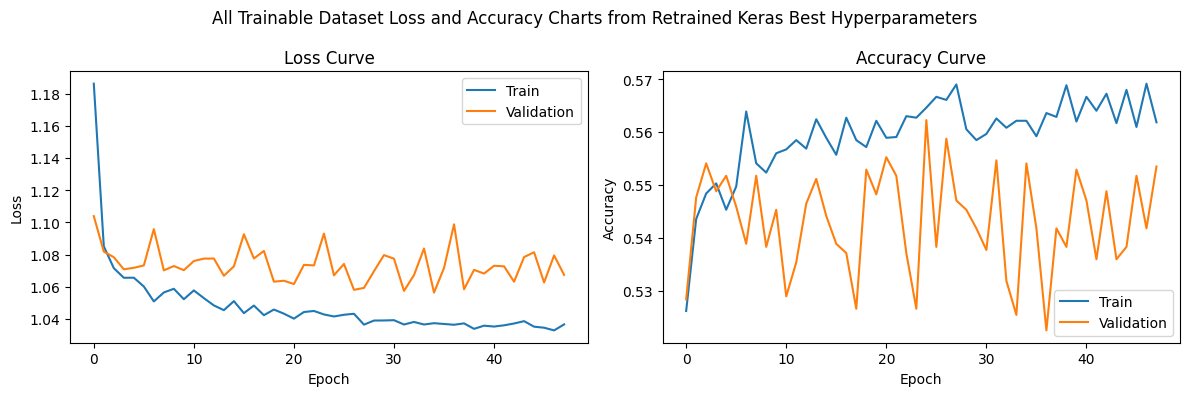

In [97]:
# Plot the loss and validation curves
plt.figure(figsize=(12, 4))

# Plot training loss curve
plt.subplot(1, 2, 1)
plt.plot(hypermodel_fit_all.history['loss'], label='Train')
plt.plot(hypermodel_fit_all.history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation accuracy curve
plt.subplot(1, 2, 2)
plt.plot(hypermodel_fit_all.history['accuracy'], label='Train')
plt.plot(hypermodel_fit_all.history['val_accuracy'], label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('All Trainable Dataset Loss and Accuracy Charts from Retrained Keras Best Hyperparameters')
plt.tight_layout()
plt.savefig('Retrain all trainable loss and accuracy charts.png')

plt.show()

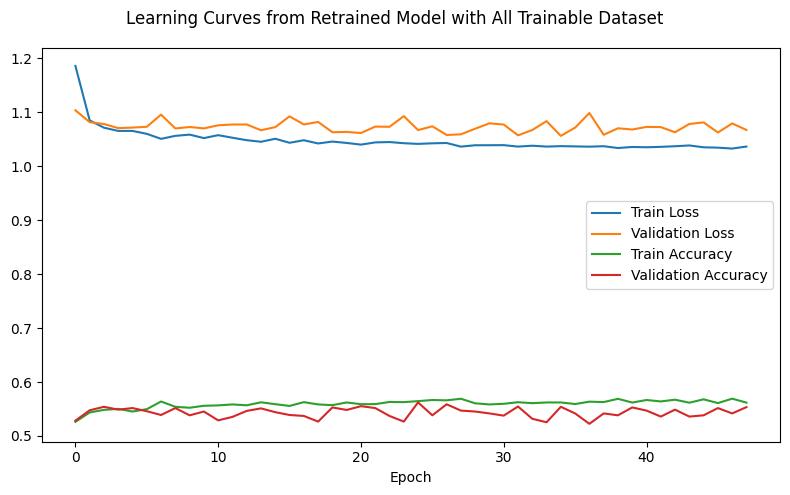

In [100]:
plt.figure(figsize=(8, 5))

# Plot training loss curve
plt.plot(hypermodel_fit_all.history['loss'], label='Train Loss')
plt.plot(hypermodel_fit_all.history['val_loss'], label='Validation Loss')

# Plot training accuracy curve
plt.plot(hypermodel_fit_all.history['accuracy'], label='Train Accuracy')
plt.plot(hypermodel_fit_all.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')

plt.suptitle('Learning Curves from Retrained Model with All Trainable Dataset')


plt.legend()
plt.tight_layout()
plt.savefig('All trainable data loss and accuracy charts.png')

plt.show()

In [104]:
# Compute the ability of retrained nn to model the data
eval_result_all = hypermodel_all.evaluate(X_val_all_scaled,y_val_c_all)
print("[validation loss, validation accuracy]:", eval_result_all)



54/54 [==============================] - 0s 3ms/step - loss: 1.0674 - accuracy: 0.5535
[validation loss, validation accuracy]: [1.0673917531967163, 0.5534775257110596]


In [107]:
y_pred_all = hypermodel_all.predict(X_val_all_scaled)
y_pred_all_df = pd.DataFrame(y_pred_all.round(2))
y_pred_all_df

54/54 [==============================] - 0s 3ms/step


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.00,0.01,0.06,0.48,0.40,0.05,0.0
1,0.0,0.0,0.0,0.01,0.08,0.67,0.22,0.02,0.00,0.0
2,0.0,0.0,0.0,0.01,0.05,0.34,0.51,0.08,0.01,0.0
3,0.0,0.0,0.0,0.01,0.05,0.36,0.50,0.07,0.01,0.0
4,0.0,0.0,0.0,0.00,0.01,0.07,0.52,0.36,0.04,0.0
...,...,...,...,...,...,...,...,...,...,...
1706,0.0,0.0,0.0,0.01,0.06,0.60,0.30,0.03,0.00,0.0
1707,0.0,0.0,0.0,0.01,0.09,0.72,0.17,0.02,0.00,0.0
1708,0.0,0.0,0.0,0.00,0.02,0.11,0.60,0.25,0.02,0.0
1709,0.0,0.0,0.0,0.01,0.06,0.54,0.36,0.03,0.00,0.0


In [120]:
# https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
# https://datascience.stackexchange.com/questions/93751/valueerror-classification-metrics-cant-handle-a-mix-of-multilabel-indicator-an

y_val_c_all = np.argmax(y_val_c_all, axis=1)
y_pred_all = np.argmax(hypermodel_all.predict(X_val_all_scaled) , axis=1)
cm = confusion_matrix(y_val_c_all, y_pred_all)
print(cm)


54/54 [==============================] - 0s 3ms/step
[[  0   0   3   2   0   0]
 [  0   0  40  15   0   0]
 [  0   0 384 190   8   0]
 [  0   0 194 487  56   0]
 [  0   0  20 183  76   0]
 [  0   0   2  31  20   0]]


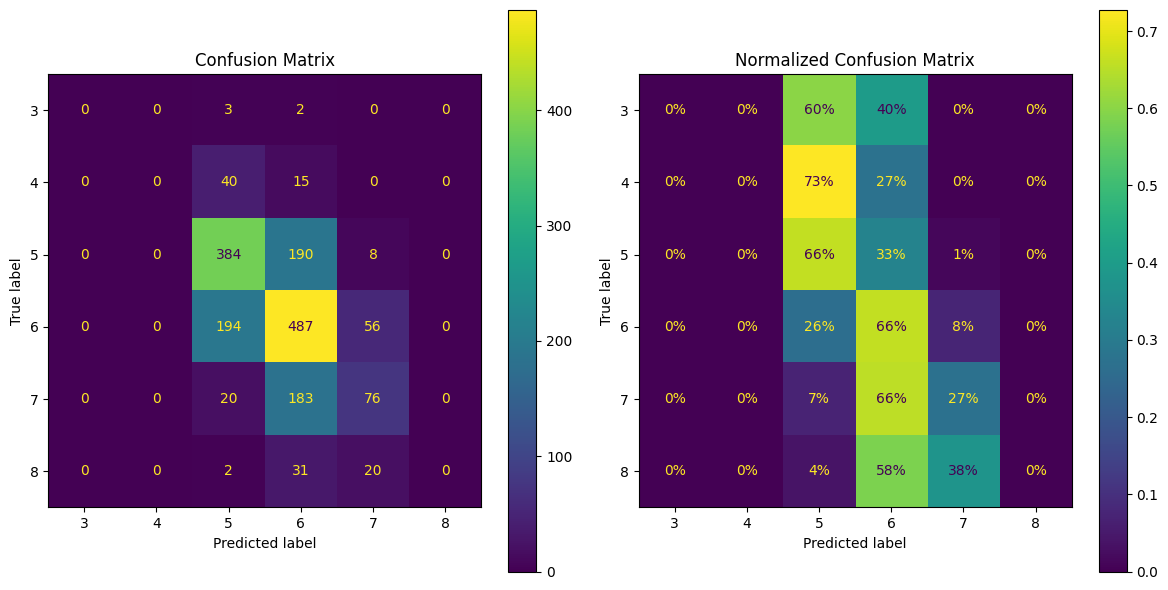

In [138]:
# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first confusion matrix
axs[0].set_title("Confusion Matrix")
conf_matrix_display_1 = ConfusionMatrixDisplay.from_predictions(y_val_c_all, y_pred_all, ax=axs[0])
# conf_matrix_display_1.plot(cmap=plt.cm.Blues, ax=axs[0])

# Calculate sample_weight
sample_weight = (y_pred_all != y_val_c_all)

# Plot the second confusion matrix
axs[1].set_title("Normalized Confusion Matrix")
conf_matrix_display_2 = ConfusionMatrixDisplay.from_predictions(y_val_c_all, y_pred_all,
                                                              #  sample_weight=sample_weight,
                                                               normalize='true',
                                                               values_format='.0%',
                                                               ax=axs[1])
# conf_matrix_display_2.plot(cmap=plt.cm.Blues, ax=axs[1])

# Adjust layout
plt.tight_layout()
plt.savefig('Confusion matrix from nn.png')
plt.show()